In [190]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import matplotlib.colors as mcolors
from mpl_toolkits.axes_grid1 import make_axes_locatable

from astropy import constants as const
import warnings
warnings.filterwarnings("ignore")
import math
import os

import seaborn as sns
from sklearn.metrics import silhouette_score, calinski_harabasz_score
from sklearn.mixture import GaussianMixture
from sklearn.cluster import DBSCAN

import scipy
from scipy.stats import norm
from scipy.stats import skewnorm
from scipy.stats import multivariate_normal
from scipy.stats import bootstrap
from scipy import interpolate
from scipy.optimize import curve_fit

## Import data and save lists

In [298]:
dataLI = pd.read_csv(r"C:\Users\silke\OneDrive\Skrivebord\Masters_Thesis\Thesis\Data\STPM_improved_210721.csv",delimiter=",")
dataEA = pd.read_csv(r"C:\Users\silke\OneDrive\Skrivebord\Masters_Thesis\Thesis\Data\2024sample_composite.csv",delimiter=",")
planet_name_LI        = list(dataLI["Star"]+" "+dataLI["Planet"])
dataLI["planet_name"] = planet_name_LI

earth_Mass = const.M_earth.value*1000 #g
earth_Radius = const.R_earth.value*100
earth_Volume = 4/3 * math.pi * earth_Radius**3
earth_density = earth_Mass / earth_Volume
    
earth_like_rocky  = pd.read_csv(r"C:\Users\silke\OneDrive\Skrivebord\Masters_Thesis\Thesis\Mass_Radius_Curves\Earth-like Rocky (32.5% Fe+67.5% MgSiO3).txt",delimiter = "\t")
H20_50_500K       = pd.read_csv(r"C:\Users\silke\OneDrive\Skrivebord\Masters_Thesis\Thesis\Mass_Radius_Curves\50% H2O (50% Earth-like rocky core + 50% H2O layer by mass)_500 K_1mili-bar surface temprture.txt",delimiter = "\t")

earth_Mass = const.M_earth.value*1000 #g
earth_Radius = const.R_earth.value*100
earth_Volume = 4/3 * math.pi * earth_Radius**3
earth_density = earth_Mass / earth_Volume

In [40]:
# Luque Impoved
planet_id_LI         = dataLI.ID
star_name_LI         = dataLI.Star
planet_letter_LI     = dataLI.Planet

radius_LI            = dataLI.R_Rterra            # [Earth Radius]
radius_unc_up_LI     = dataLI.euR_Rterra          # [Earth Radius] Upper Unc.
radius_unc_low_LI    = dataLI.edR_Rterra          # [Earth Radius] Lower Unc.

mass_LI              = dataLI.M_Mterra            # [Earth Mass] - Planet Mass or Mass*sin(i) [Earth Mass]
mass_unc_up_LI       = dataLI.euM_Mterra          # [Earth Mass] Upper Unc.
mass_unc_low_LI      = dataLI.edM_Mterra          # [Earth Mass] Lower Unc.

density_LI           = dataLI[dataLI.columns[32]]  # [g/cm**3]
density_unc_up_LI    = dataLI[dataLI.columns[33]]  # [g/cm**3] Planet Density Upper Unc. 
density_unc_low_LI   = dataLI[dataLI.columns[34]]  # [g/cm**3] Planet Density Lower Unc
star_eff_LI          = dataLI.Teff_K
pl_eq_LI             = dataLI.Teq_K                # [K] Equilibrium Temperature

# Exoplanet Archive
planet_name_EA       = dataEA.pl_name
planet_id_EA         = list(range(0,len(planet_name_EA)))

radius_EA            = dataEA.pl_rade            # [Earth Radius]
period_EA            = dataEA.pl_orbper          # [days]
radius_unc_up_EA     = dataEA.pl_radeerr1        # [Earth Radius] Upper Unc.
radius_unc_low_EA    = dataEA.pl_radeerr2        # [Earth Radius] Lower Unc.
mass_EA              = dataEA.pl_bmasse          # [Earth Mass] - Planet Mass or Mass*sin(i) [Earth Mass]

mass_unc_up_EA       = dataEA.pl_bmasseerr1      # [Earth Mass] Upper Unc.
mass_unc_low_EA      = dataEA.pl_bmasseerr2      # [Earth Mass] Lower Unc.

density_EA           = dataEA.pl_dens            # [g/cm**3]
density_unc_up_EA    = dataEA.pl_denserr1        # [g/cm**3] Planet Density Upper Unc. 
density_unc_low_EA   = dataEA.pl_denserr2        # [g/cm**3] Planet Density Lower Unc. 
st_spectype_EA       = dataEA.st_spectype        # Spectral type of star
pl_eq_EA             = dataEA.pl_eqt             # [K] Equilibrium Temperature
st_eff_EA            = dataEA.st_teff            # Star effective temprature
st_eff_up_EA         = dataEA.st_tefferr1        # Star upper err effective temprature
st_eff_low_EA        = dataEA.st_tefferr2        # Star lower err effective temprature
disc_year_EA         = dataEA.disc_year


In [452]:
planets = ["K2-146 b",'TRAPPIST-1 h', 'TRAPPIST-1 d', 'TRAPPIST-1 e', 'TRAPPIST-1 f', 'TRAPPIST-1 g', 'TRAPPIST-1 c', 'TRAPPIST-1 b', 'GJ 1132 b', 'TOI-270 b', 'GJ 3053 c', 'GJ 1252 b', 'GJ 357 b', 'LTT 3780 b', 'LHS 1478 b', 'GJ 486 b', 'GJ 3473 b', 'CD-60 8051 b', 'L 98-59 c', 'L 98-59 d', 'GJ 3053 b', 'TOI-270 d', 'TOI-776 b', 'TOI-1634 b', 'TOI-1685 b', 'TOI-1235 b', 'K2-146 c', 'LTT 3780 c', 'TOI-270 c', 'K2-18 b', 'TOI-269 b', 'GJ 1214 b', 'K2-25 b', 'TOI-1231 b']
planet1      = []; planet_i1       = []; planet_eq1   = []
disc_year1   = []; st_eff1         = []; st_type1     = []
radius1      = []; radius_up1      = []; radius_low1  = []
mass1        = []; mass_up1        = []; mass_low1    = []
density1     = []; density_up1     = []; density_low1 = []

for i in range(0,len(planet_name_LI)):
    if planet_name_LI[i] in planets:
        planet1.append(planet_name_LI[i]); planet_eq1.append(pl_eq_LI[i]);          st_eff1.append(star_eff_LI[i]);
        radius1.append(radius_LI[i]);      radius_up1.append(radius_unc_up_LI[i]);  radius_low1.append(radius_unc_low_LI[i]);
        mass1.append(mass_LI[i]);          mass_up1.append(mass_unc_up_LI[i]);      mass_low1.append(mass_unc_low_LI[i]);
        density1.append(density_LI[i]);    density_up1.append(density_unc_up_LI[i]); density_low1.append(density_unc_low_LI[i]);

In [44]:
planet_EA_unique = list(set(planet_name_EA))
other_names = ["LHS 1140 b",'LHS 1140 c' ,'L 168-9 b', 'L 168-9 c', "GJ 3053 b","GJ 3053 c"]

radius_4_crit     = []
mass_err_crit     = []
radius_err_crit   = []
stellar_type_crit = []
st_eff_crit       = []
density_crit      = []
for i in range(0,len(planet_name_EA)):
    if planet_name_EA[i] not in planet_name_LI and planet_name_EA[i] not in other_names and planet_name_EA[i]:
        if planet_name_EA[i] not in radius_4_crit and radius_EA[i]<4:
            radius_4_crit.append(planet_name_EA[i])
        if planet_name_EA[i] not in mass_err_crit and ((mass_unc_up_EA[i] + mass_unc_up_EA[i])*0.5) / mass_EA[i] < 0.50:
            mass_err_crit.append(planet_name_EA[i])    
        if planet_name_EA[i] not in radius_err_crit and ((radius_unc_up_EA[i] + radius_unc_up_EA[i])*0.5) / radius_EA[i] < 0.50:
            radius_err_crit.append(planet_name_EA[i])   
        if planet_name_EA[i] not in stellar_type_crit and "M" in str(st_spectype_EA[i]):
            stellar_type_crit.append(planet_name_EA[i])   
        if planet_name_EA[i] not in density_crit and True != math.isnan(density_unc_up_EA[i]):
            density_crit.append(planet_name_EA[i])   

list1 = radius_4_crit;   list2 = mass_err_crit; 
list3 = radius_err_crit; list4 = stellar_type_crit; 
list5 = density_crit

common_elements = np.sort(list(set(list1) & set(list2) & set(list3) & set(list4) & set(list5)))

planet2      = []; planet_i2       = []; planet_eq2   = []
disc_year2   = []; st_eff2         = []
radius2      = []; radius_up2      = []; radius_low2  = []
mass2        = []; mass_up2        = []; mass_low2    = []
density2     = []; density_up2     = []; density_low2 = []

for j in range(0,len(common_elements)):
    target_string = str(common_elements[j])
    indexs = [index for index, value in enumerate(planet_name_EA) if value == target_string]
    i = indexs[0]
    if st_eff_EA[i] < 4000:
        st_eff2.append(st_eff_EA[i])
        planet_eq2.append(pl_eq_EA[i]); planet2.append(planet_name_EA[i]); disc_year2.append(disc_year_EA[i])
        radius2.append(dataEA.pl_rade[i]); radius_up2.append(dataEA.pl_radeerr1[i]); radius_low2.append(dataEA.pl_radeerr2[i])
        density2.append(dataEA.pl_dens[i]); density_up2.append(dataEA.pl_denserr1[i]); density_low2.append(dataEA.pl_denserr2[i])
        mass2.append(dataEA.pl_bmasse[i]); mass_up2.append(dataEA.pl_bmasseerr1[i]);  mass_low2.append(dataEA.pl_bmasseerr2[i])

In [453]:
earth_like_rocky_mass_g        = earth_Mass*np.array(earth_like_rocky["Mass"])
earth_like_rocky_radius_cm     = earth_Radius*np.array(earth_like_rocky["Radius"])
earth_like_rocky_density_g_cm3 = (earth_like_rocky_mass_g) / ((4/3)*(np.pi)*(np.power(earth_like_rocky_radius_cm,3))   ) 

H20_50_500K_mass_g        = earth_Mass*np.array(H20_50_500K["Mass"])
H20_50_500K_radius_cm     = earth_Radius*np.array(H20_50_500K["Radius"])
H20_50_500K_density_g_cm3 = (H20_50_500K_mass_g) / ((4/3)*(np.pi)*(np.power(H20_50_500K_radius_cm,3))   ) 


def rocky_density(mass):
    x_points  = earth_like_rocky["Mass"]
    y_points  = earth_like_rocky_density_g_cm3
    tck       = interpolate.splrep(x_points, y_points)
    return interpolate.splev(mass, tck).tolist()

def rocky_density2(mass):
    x_points  = earth_like_rocky["Mass"]
    y_points  = earth_like_rocky_density_g_cm3/earth_like_rocky_density_g_cm3
    tck       = interpolate.splrep(x_points, y_points)
    return interpolate.splev(mass, tck).tolist()

def h20model_density(mass):
    x_points  = H20_50_500K["Mass"]
    y_points  = H20_50_500K_density_g_cm3/rocky_density(H20_50_500K["Mass"])
    tck       = interpolate.splrep(x_points, y_points)
    return interpolate.splev(mass, tck).tolist()

mass    = np.concatenate((mass1, mass2));       mass_up     = np.concatenate((mass_up1, mass_up2));       mass_low     = np.concatenate((mass_low1, mass_low2));
radius  = np.concatenate((radius1, radius2));   radius_up   = np.concatenate((radius_up1, radius_up2));   radius_low   = np.concatenate((radius_low1, radius_low2));
density = np.concatenate((np.array(density1) / rocky_density(mass1), np.array(density2)/ rocky_density(mass2))); density_up  = np.concatenate((np.array(density_up1)/ rocky_density(mass1), np.array(density_up2)/ rocky_density(mass2))); density_low  = np.concatenate((np.array(density_low1)/ rocky_density(mass1),np.array(density_low2)/ rocky_density(mass2)));
density_nonnorm = np.concatenate((np.array(density1), np.array(density2))); density_upnonnorm  = np.concatenate((np.array(density_up1), np.array(density_up2))); density_lownonnorm  = np.concatenate((np.array(density_low1),np.array(density_low2)));

planet_temp = np.concatenate((planet_eq1, planet_eq2));
planet_name = np.concatenate((planet1,    planet2));
star_eff    = np.concatenate((st_eff1,    st_eff2));
disc_year   = np.concatenate((disc_year1,    disc_year2));

mass_err    = [np.abs(mass_low),mass_up]
radius_err  = [np.abs(radius_low),radius_up]
density_err = [np.abs(density_low),density_up]

density_errnonnorm = [np.abs(density_lownonnorm),density_upnonnorm]

mass10      = np.log10(mass)
mass10_up   = np.log10(mass + mass_up) - np.log10(mass)
mass10_low  = np.log10(mass + np.abs(mass_low)) - np.log10(mass)
mass10_err  = [mass10_low,mass10_up]

mass_err1    = [np.abs(mass_low1),mass_up1]
radius_err1  = [np.abs(radius_low1),radius_up1]

density1_norm = np.array(density1) / rocky_density(mass1)
density_low1_norm = (np.array(density_low1)/ rocky_density(mass1)); 
density_up1_norm  = (np.array(density_up1) / rocky_density(mass1)); 
density_err1_norm = [density_low1_norm,density_up1_norm]

mass10_up1   = np.log10(np.array(mass1) + np.array(mass_up1))  - np.log10(mass1)
mass10_low1  = np.log10(np.array(mass1) + np.array(mass_low1)) - np.log10(mass1)
mass10_err1  = [mass10_low1,mass10_up1]

model_rocky_density = np.array(rocky_density(np.array(earth_like_rocky["Mass"])))
model_rocky_mass    = np.array(earth_like_rocky["Mass"])
model_rocky10_mass  = np.array(np.log10(np.array(earth_like_rocky["Mass"])))
model_rocky_radius  = np.array(earth_like_rocky["Radius"])

In [236]:
def filter_planets(planet_name_list,rel_unc_mass_criteria,rel_unc_density_criteria):
    EA_planets = []
    for i in range(0,len(planet_name_list)):
        if radius_EA[i]<4 and isinstance(st_spectype_EA[i],str) and "M" in st_spectype_EA[i]:
            relative_uncertainty_mass    = (mass_unc_up_EA[i] - mass_unc_low_EA[i]) / (2 * mass_EA[i])
            relative_uncertainty_density = (density_unc_up_EA[i] - density_unc_low_EA[i]) / (2 * density_EA[i])
            if relative_uncertainty_mass < rel_unc_mass_criteria and relative_uncertainty_density < rel_unc_density_criteria:
                EA_planets.append(planet_name_list[i])
    EA_add_index = [5209,5210,5211,5212,5213,5214,5215]
        for i in EA_add_index:
            EA_planets.append(planet_name_EA[i])
    return EA_planets

def make_lists(EA_planets):
    planet      = [];planet_i       = []; 
    radius      = []; radius_up     = []; radius_low  = []
    mass        = [];  mass_up      = []; mass_low    = []
    density     = []; density_up    = []; density_low = []

    for i in range(0,len(EA_planets)):
        index  = list(planet_name_EA).index(EA_planets[i]); planet.append(dataEA.pl_name[index])
        radius.append(dataEA.pl_rade[index]); radius_up.append(dataEA.pl_radeerr1[index]); radius_low.append(dataEA.pl_radeerr2[index])
        density.append(dataEA.pl_dens[index]); density_up.append(dataEA.pl_denserr1[index]); density_low.append(dataEA.pl_denserr2[index])
        mass.append(dataEA.pl_bmasse[index]); mass_up.append(dataEA.pl_bmasseerr1[index]);  mass_low.append(dataEA.pl_bmasseerr2[index])
    return index,planet,radius,radius_up,radius_low,density,density_up,density_low,mass,mass_up,mass_low
def find_planet_index(name):
    return (list(planet_name_list).index(name))

## The 2024 sample

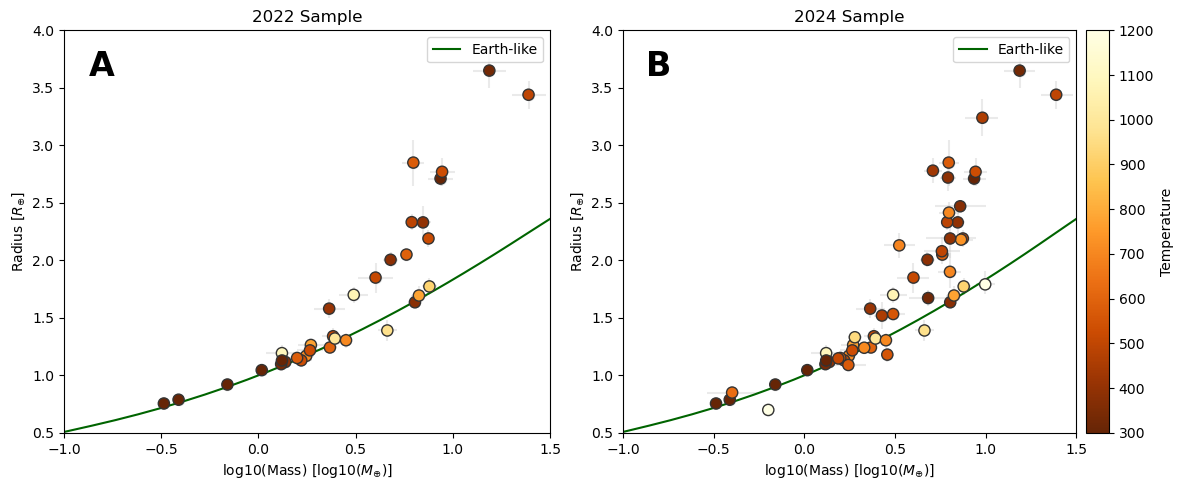

In [304]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
# Add subplot A
ax = axes[0]
norm = mcolors.Normalize(vmin=300, vmax=1200)
cmap = plt.cm.get_cmap('YlOrBr_r')

ax.plot(np.log10(list(earth_like_rocky["Mass"])), list(earth_like_rocky["Radius"]), "-", color="Darkgreen", label="Earth-like",zorder = -10)
ax.scatter(np.log10(mass1), radius1, c=planet_eq1, cmap=cmap, norm=norm, marker='o', s=65, edgecolors='0.2')
ax.errorbar(np.log10(mass1), radius1, xerr=mass10_err1, yerr=radius_err1, fmt='.', markersize=15, color="0.8", zorder=-32, alpha=0.4)
ax.set_xlim(-1, 1.5)
ax.set_ylim(0.5, 4)
ax.set_xlabel("log10(Mass) [log10($M_{\oplus})]$")
ax.set_ylabel("Radius $[R_{\oplus}]$")
ax.legend(loc=1)
ax.text(0.05, 0.95, "A", transform=ax.transAxes, fontsize=24, fontweight='bold', va='top', ha='left')
ax.set_title("2022 Sample")

# Add subplot B
ax = axes[1]
norm = mcolors.Normalize(vmin=300, vmax=1200)
cmap = plt.cm.get_cmap('YlOrBr_r')
ax.plot(np.log10(list(earth_like_rocky["Mass"])), list(earth_like_rocky["Radius"]), "-", color="Darkgreen", label="Earth-like",zorder = -10)
ax.scatter(mass10, radius, c=planet_temp, cmap=cmap, norm=norm, marker='o', s=65, edgecolors='0.2')
ax.errorbar(mass10, radius, xerr=mass10_err, yerr=radius_err, fmt='.', markersize=15, color="0.8", zorder=-32, alpha=0.4)
ax.set_xlim(-1, 1.5)
ax.set_ylim(0.5, 4)
ax.set_xlabel("log10(Mass) [log10($M_{\oplus})]$")
ax.set_ylabel("Radius $[R_{\oplus}]$")
ax.legend(loc=1)
ax.text(0.05, 0.95, "B", transform=ax.transAxes, fontsize=24, fontweight='bold', va='top', ha='left')
ax.set_title("2024 Sample")

# Adjust layout with more vertical space after the colorbar
plt.tight_layout(rect=[0, 0, 0.95, 1])  # Adjust the 'right' parameter to leave space for the colorbar
plt.subplots_adjust(wspace=0.15)

# Add colorbar with its own space
divider = make_axes_locatable(axes[1])
cax = divider.append_axes("right", size="5%", pad=0.1)
cbar = plt.colorbar(scatter_c, cax=cax, label='Temperature')  # Add label to the colorbar

folder_path = 'Figures_WhereAreTheWaterWorlds'
if not os.path.exists(folder_path):
    os.makedirs(folder_path)

# Define the image name within the folder
image_name = os.path.join(folder_path, 'Sample_compare.png')

# Set the image format
image_format = 'png'

# Save the figure
#fig.savefig(image_name, format=image_format, dpi=1200)

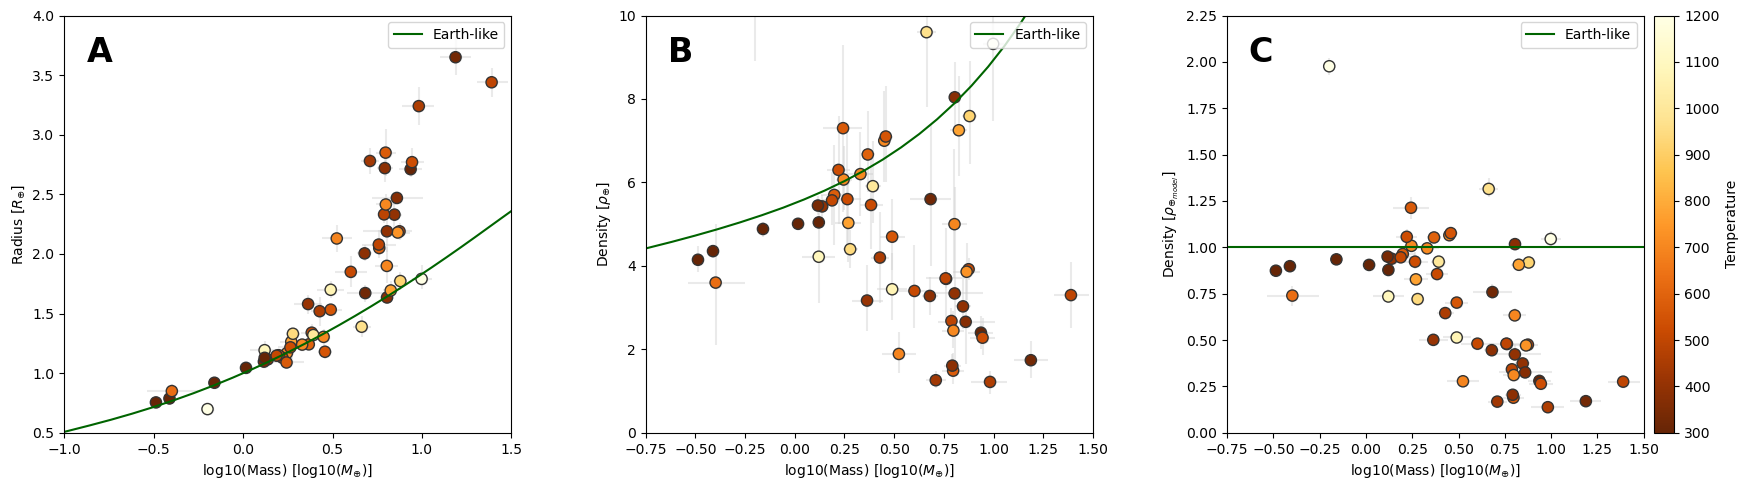

In [245]:
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Add subplot A
ax = axes[0]
norm = mcolors.Normalize(vmin=300, vmax=1200)
cmap = plt.cm.get_cmap('YlOrBr_r')
ax.plot(np.log10(list(earth_like_rocky["Mass"])), list(earth_like_rocky["Radius"]), "-", color="Darkgreen", label="Earth-like")
ax.scatter(mass10, radius, c=planet_temp, cmap=cmap, norm=norm, marker='o', s=65, edgecolors='0.2')
ax.errorbar(mass10, radius, xerr=mass10_err, yerr=radius_err, fmt='.', markersize=15, color="0.8", zorder=-32, alpha=0.4)
ax.set_xlim(-1, 1.5)
ax.set_ylim(0.5, 4)
ax.set_xlabel("log10(Mass) [log10($M_{\oplus})]$")
ax.set_ylabel("Radius $[R_{\oplus}]$")
ax.legend(loc=1)
ax.text(0.05, 0.95, "A", transform=ax.transAxes, fontsize=24, fontweight='bold', va='top', ha='left')

# Add subplot B
ax = axes[1]
ax.scatter(mass10, density_nonnorm, c=planet_temp, cmap=cmap, norm=norm, marker='o', s=65, edgecolors='0.2')
ax.errorbar(mass10, density_nonnorm, xerr=mass10_err, yerr=density_errnonnorm, fmt='.', markersize=15, color="0.8", zorder=-32, alpha=0.4)
ax.plot(np.log10(earth_like_rocky["Mass"]), np.array(rocky_density(list(earth_like_rocky["Mass"]))), "-", color="Darkgreen", label="Earth-like")
ax.set_xlim(-0.75, 1.5)
ax.set_ylim(0, 10)
ax.set_xlabel("log10(Mass) [log10($M_{\oplus})]$")
ax.set_ylabel("Density $[ρ_{\oplus}]$")
ax.legend(loc=1)
ax.text(0.05, 0.95, "B", transform=ax.transAxes, fontsize=24, fontweight='bold', va='top', ha='left')

# Add subplot C
ax = axes[2]
scatter_c = ax.scatter(mass10, density, c=planet_temp, cmap=cmap, norm=norm, marker='o', s=65, edgecolors='0.2')
ax.errorbar(mass10, density, xerr=mass10_err, yerr=density_err, fmt='.', markersize=15, color="0.8", zorder=-32, alpha=0.4)
ax.plot(np.log10(earth_like_rocky["Mass"]), np.array(rocky_density(list(earth_like_rocky["Mass"]))) / np.array(rocky_density(list(earth_like_rocky["Mass"]))), "-", color="Darkgreen", label="Earth-like")
ax.set_xlim(-0.75, 1.5)
ax.set_ylim(0, 2.25)
ax.set_xlabel("log10(Mass) [log10($M_{\oplus})]$")
ax.set_ylabel("Density $[ρ_{ \oplus_{model}}]$")
ax.legend(loc=1)
ax.text(0.05, 0.95, "C", transform=ax.transAxes, fontsize=24, fontweight='bold', va='top', ha='left')

# Adjust layout with more vertical space after the colorbar
plt.tight_layout(rect=[0, 0, 0.95, 1])  # Adjust the 'right' parameter to leave space for the colorbar
plt.subplots_adjust(wspace=0.3)

# Add colorbar with its own space
divider = make_axes_locatable(axes[2])
cax = divider.append_axes("right", size="5%", pad=0.1)
cbar = plt.colorbar(scatter_c, cax=cax, label='Temperature')  # Add label to the colorbar

folder_path = 'Figures_WhereAreTheWaterWorlds'
if not os.path.exists(folder_path):
    os.makedirs(folder_path)

# Define the image name within the folder
image_name = os.path.join(folder_path, '2024sample.png')

# Set the image format
image_format = 'png'

# Save the figure
#fig.savefig(image_name, format=image_format, dpi=1200)

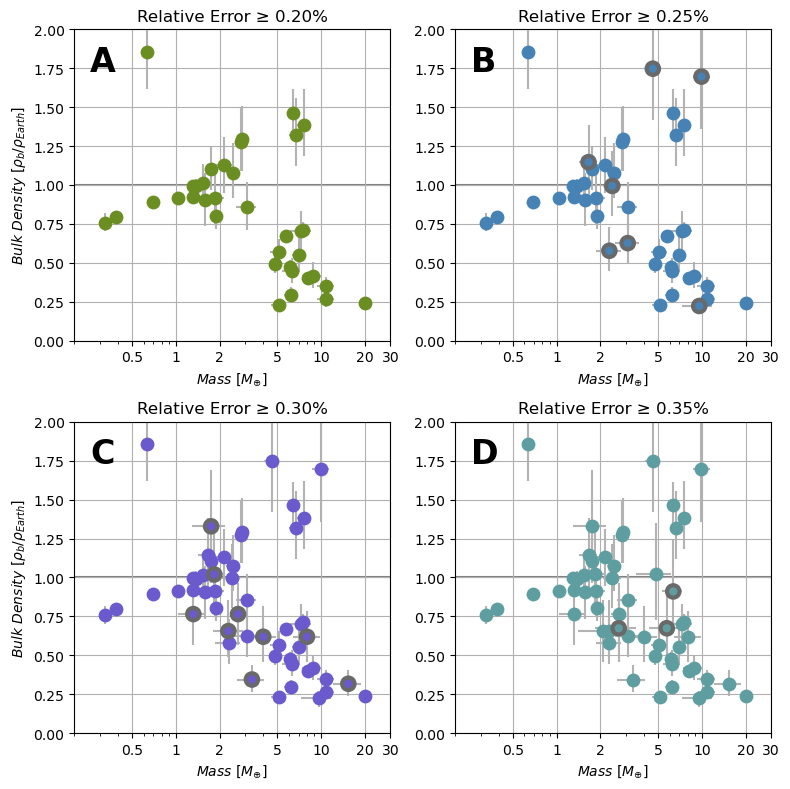

In [237]:
mass20 = []; mass25 = []; mass30 = []; mass35 = []; 
density20 = []; density25 = []; density30 = []; density35 = []; 
fig, ax = plt.subplots(figsize=(8,8))

# Add subplot A
plt.subplot(2, 2, 1)
EA_planets = filter_planets(planet_name_EA,0.20,0.20)
index,planet,radius,radius_up,radius_low,density,density_up,density_low,mass,mass_up,mass_low = make_lists(EA_planets)
mass20 = mass; density20 = density

mass_err = [np.abs(mass_low), mass_up]
density_err = [np.divide(np.abs(density_low), earth_density), np.divide(density_up, earth_density)]
plt.errorbar(mass, np.divide(density, earth_density), xerr=mass_err, yerr=density_err, fmt=".", color="0.7", zorder=-18)
plt.scatter(mass, np.divide(density, earth_density), color="olivedrab",s = 80,zorder=10)
plt.xlabel("$Mass\ [M_{\oplus}]$")
plt.ylabel("$Bulk\ Density\ [ρ_{b}/ρ_{Earth}]$")
plt.xscale("log")
plt.title("Relative Error ≥ 0.20%")
plt.ylim(0, 2)
plt.xlim(0.2, 30)
plt.xticks([0.5, 1, 2, 5, 10, 20, 30], ["0.5", "1", "2", "5", "10", "20", "30"], minor=False)
plt.hlines(1, 0, 30, "grey", zorder=-30)
plt.grid(zorder=-30)
plt.text(0.05, 0.95, "A", transform=plt.gca().transAxes, fontsize=24, fontweight='bold', va='top', ha='left')

# Add subplot B
plt.subplot(2, 2, 2)
EA_planets = filter_planets(planet_name_EA,0.25,0.25)
index,planet,radius,radius_up,radius_low,density,density_up,density_low,mass,mass_up,mass_low = make_lists(EA_planets)
mass25 = mass; density25 = density
plt.scatter(mass, np.divide(density, earth_density),  color="steelblue",s = 80,zorder=10)
mass_err = [np.abs(mass_low), mass_up]
density_err = [np.divide(np.abs(density_low), earth_density), np.divide(density_up, earth_density)]
plt.errorbar(mass, np.divide(density, earth_density), xerr=mass_err, yerr=density_err, fmt=".", color="0.7", zorder=-18)

unique_indices_density25 = [i for i, d in enumerate(density25) if d not in density20]
unique_density25 = [density25[i] for i in unique_indices_density25]
unique_mass25 = [mass25[i] for i in unique_indices_density25]
plt.scatter(unique_mass25, np.divide(unique_density25, earth_density), facecolors='none',s=80, edgecolors='dimgray', linewidths=3,zorder=11) 

plt.xlabel("$Mass\ [M_{\oplus}]$")
plt.xscale("log")
plt.title("Relative Error ≥ 0.25%")
plt.ylim(0, 2)
plt.xlim(0.2, 30)
plt.xticks([0.5, 1, 2, 5, 10, 20, 30], ["0.5", "1", "2", "5", "10", "20", "30"], minor=False)
plt.hlines(1, 0, 30, "grey", zorder=-30)
plt.grid(zorder=-30)
plt.text(0.05, 0.95, "B", transform=plt.gca().transAxes, fontsize=24, fontweight='bold', va='top', ha='left')

# Add subplot C
plt.subplot(2, 2, 3)
EA_planets = filter_planets(planet_name_EA,0.30,0.30)
index,planet,radius,radius_up,radius_low,density,density_up,density_low,mass,mass_up,mass_low = make_lists(EA_planets)
mass30 = mass; density30 = density
mass_err = [np.abs(mass_low), mass_up]
density_err = [np.divide(np.abs(density_low), earth_density), np.divide(density_up, earth_density)]
plt.scatter(mass, np.divide(density, earth_density), s = 80, color="slateblue",zorder = 10)
mass_err = [np.abs(mass_low), mass_up]
density_err = [np.divide(np.abs(density_low), earth_density), np.divide(density_up, earth_density)]
plt.errorbar(mass, np.divide(density, earth_density), xerr=mass_err, yerr=density_err, fmt=".", color="0.7", zorder=-18)

unique_indices_density30 = [i for i, d in enumerate(density30) if d not in density25]
unique_density30 = [density30[i] for i in unique_indices_density30]
unique_mass30 = [mass30[i] for i in unique_indices_density30]
plt.scatter(unique_mass30, np.divide(unique_density30, earth_density), facecolors='none',s=80, edgecolors='dimgray', linewidths=3,zorder=11)


plt.xlabel("$Mass\ [M_{\oplus}]$")
plt.ylabel("$Bulk\ Density\ [ρ_{b}/ρ_{Earth}]$")
plt.xscale("log")
plt.title("Relative Error ≥ 0.30%")
plt.ylim(0, 2)
plt.xlim(0.2, 30)
plt.xticks([0.5, 1, 2, 5, 10, 20, 30], ["0.5", "1", "2", "5", "10", "20", "30"], minor=False)
plt.hlines(1, 0, 30, "grey", zorder=-30)
plt.grid()
plt.text(0.05, 0.95, "C", transform=plt.gca().transAxes, fontsize=24, fontweight='bold', va='top', ha='left')

# Add subplot D
plt.subplot(2, 2, 4)
EA_planets = filter_planets(planet_name_EA,0.35,0.35)
index,planet,radius,radius_up,radius_low,density,density_up,density_low,mass,mass_up,mass_low = make_lists(EA_planets)
mass35 = mass; density35 = density
mass_err = [np.abs(mass_low), mass_up]
density_err = [np.divide(np.abs(density_low), earth_density), np.divide(density_up, earth_density)]
plt.scatter(mass, np.divide(density, earth_density), s = 80, color="cadetblue",zorder = 10)
mass_err = [np.abs(mass_low), mass_up]
density_err = [np.divide(np.abs(density_low), earth_density), np.divide(density_up, earth_density)]
plt.errorbar(mass, np.divide(density, earth_density), xerr=mass_err, yerr=density_err, fmt=".", color="0.7", zorder=-18)

unique_indices_density35 = [i for i, d in enumerate(density35) if d not in density30]
unique_density35 = [density35[i] for i in unique_indices_density35]
unique_mass35 = [mass35[i] for i in unique_indices_density35]
plt.scatter(unique_mass35, np.divide(unique_density35, earth_density), facecolors='none',s=80, edgecolors='dimgray', linewidths=3,zorder=11)


plt.xlabel("$Mass\ [M_{\oplus}]$")
plt.xscale("log")
plt.title("Relative Error ≥ 0.35%")
plt.ylim(0, 2)
plt.xlim(0.2, 30)
plt.xticks([0.5, 1, 2, 5, 10, 20, 30], ["0.5", "1", "2", "5", "10", "20", "30"], minor=False)
plt.hlines(1, 0, 30, "grey", zorder=-30)
plt.grid()
plt.text(0.05, 0.95, "D", transform=plt.gca().transAxes, fontsize=24, fontweight='bold', va='top', ha='left')
plt.tight_layout()

folder_path = 'Figures_WhereAreTheWaterWorlds'
if not os.path.exists(folder_path):
    os.makedirs(folder_path)

# Define the image name within the folder
image_name = os.path.join(folder_path, 'Relative_Error_ring.png')

# Set the image format
image_format = 'png'

# Save the figure
fig.savefig(image_name, format=image_format, dpi=1200)

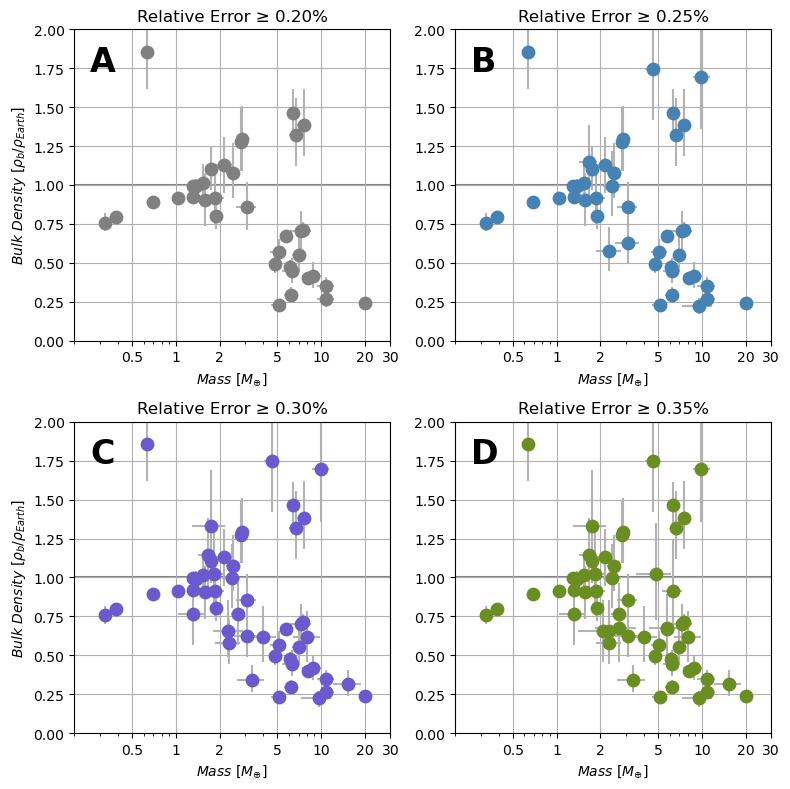

In [238]:
mass20 = []; mass25 = []; mass30 = []; mass35 = []; 
density20 = []; density25 = []; density30 = []; density35 = []; 
fig, ax = plt.subplots(figsize=(8,8))

# Add subplot A
plt.subplot(2, 2, 1)
EA_planets = filter_planets(planet_name_EA,0.20,0.20)
index,planet,radius,radius_up,radius_low,density,density_up,density_low,mass,mass_up,mass_low = make_lists(EA_planets)
mass20 = mass; density20 = density

mass_err = [np.abs(mass_low), mass_up]
density_err = [np.divide(np.abs(density_low), earth_density), np.divide(density_up, earth_density)]
plt.errorbar(mass, np.divide(density, earth_density), xerr=mass_err, yerr=density_err, fmt=".", color="0.7", zorder=-18)
plt.scatter(mass, np.divide(density, earth_density), color="grey",s = 80,zorder=10)
plt.xlabel("$Mass\ [M_{\oplus}]$")
plt.ylabel("$Bulk\ Density\ [ρ_{b}/ρ_{Earth}]$")
plt.xscale("log")
plt.title("Relative Error ≥ 0.20%")
plt.ylim(0, 2)
plt.xlim(0.2, 30)
plt.xticks([0.5, 1, 2, 5, 10, 20, 30], ["0.5", "1", "2", "5", "10", "20", "30"], minor=False)
plt.hlines(1, 0, 30, "grey", zorder=-30)
plt.grid(zorder=-30)
plt.text(0.05, 0.95, "A", transform=plt.gca().transAxes, fontsize=24, fontweight='bold', va='top', ha='left')

# Add subplot B
plt.subplot(2, 2, 2)
EA_planets = filter_planets(planet_name_EA,0.25,0.25)
index,planet,radius,radius_up,radius_low,density,density_up,density_low,mass,mass_up,mass_low = make_lists(EA_planets)
plt.scatter(mass, np.divide(density, earth_density),  color="steelblue",s = 80,zorder=10)
mass_err = [np.abs(mass_low), mass_up]
density_err = [np.divide(np.abs(density_low), earth_density), np.divide(density_up, earth_density)]
plt.errorbar(mass, np.divide(density, earth_density), xerr=mass_err, yerr=density_err, fmt=".", color="0.7", zorder=-18)
plt.xlabel("$Mass\ [M_{\oplus}]$")
plt.xscale("log")
plt.title("Relative Error ≥ 0.25%")
plt.ylim(0, 2)
plt.xlim(0.2, 30)
plt.xticks([0.5, 1, 2, 5, 10, 20, 30], ["0.5", "1", "2", "5", "10", "20", "30"], minor=False)
plt.hlines(1, 0, 30, "grey", zorder=-30)
plt.grid(zorder=-30)
plt.text(0.05, 0.95, "B", transform=plt.gca().transAxes, fontsize=24, fontweight='bold', va='top', ha='left')

# Add subplot C
plt.subplot(2, 2, 3)
EA_planets = filter_planets(planet_name_EA,0.30,0.30)
index,planet,radius,radius_up,radius_low,density,density_up,density_low,mass,mass_up,mass_low = make_lists(EA_planets)
mass_err = [np.abs(mass_low), mass_up]
density_err = [np.divide(np.abs(density_low), earth_density), np.divide(density_up, earth_density)]
plt.scatter(mass, np.divide(density, earth_density), s = 80, color="slateblue",zorder = 10)
mass_err = [np.abs(mass_low), mass_up]
density_err = [np.divide(np.abs(density_low), earth_density), np.divide(density_up, earth_density)]
plt.errorbar(mass, np.divide(density, earth_density), xerr=mass_err, yerr=density_err, fmt=".", color="0.7", zorder=-18)
plt.xlabel("$Mass\ [M_{\oplus}]$")
plt.ylabel("$Bulk\ Density\ [ρ_{b}/ρ_{Earth}]$")
plt.xscale("log")
plt.title("Relative Error ≥ 0.30%")
plt.ylim(0, 2)
plt.xlim(0.2, 30)
plt.xticks([0.5, 1, 2, 5, 10, 20, 30], ["0.5", "1", "2", "5", "10", "20", "30"], minor=False)
plt.hlines(1, 0, 30, "grey", zorder=-30)
plt.grid()
plt.text(0.05, 0.95, "C", transform=plt.gca().transAxes, fontsize=24, fontweight='bold', va='top', ha='left')

# Add subplot D
plt.subplot(2, 2, 4)
EA_planets = filter_planets(planet_name_EA,0.35,0.35)
index,planet,radius,radius_up,radius_low,density,density_up,density_low,mass,mass_up,mass_low = make_lists(EA_planets)
mass_err = [np.abs(mass_low), mass_up]
density_err = [np.divide(np.abs(density_low), earth_density), np.divide(density_up, earth_density)]
plt.scatter(mass, np.divide(density, earth_density), s = 80, color="olivedrab",zorder = 10)
mass_err = [np.abs(mass_low), mass_up]
density_err = [np.divide(np.abs(density_low), earth_density), np.divide(density_up, earth_density)]
plt.errorbar(mass, np.divide(density, earth_density), xerr=mass_err, yerr=density_err, fmt=".", color="0.7", zorder=-18)
plt.xlabel("$Mass\ [M_{\oplus}]$")
plt.xscale("log")
plt.title("Relative Error ≥ 0.35%")
plt.ylim(0, 2)
plt.xlim(0.2, 30)
plt.xticks([0.5, 1, 2, 5, 10, 20, 30], ["0.5", "1", "2", "5", "10", "20", "30"], minor=False)
plt.hlines(1, 0, 30, "grey", zorder=-30)
plt.grid()
plt.text(0.05, 0.95, "D", transform=plt.gca().transAxes, fontsize=24, fontweight='bold', va='top', ha='left')
plt.tight_layout()

folder_path = 'Figures_WhereAreTheWaterWorlds'
if not os.path.exists(folder_path):
    os.makedirs(folder_path)

# Define the image name within the folder
image_name = os.path.join(folder_path, 'Relative_Error.png')

# Set the image format
image_format = 'png'

# Save the figure
fig.savefig(image_name, format=image_format, dpi=1200)

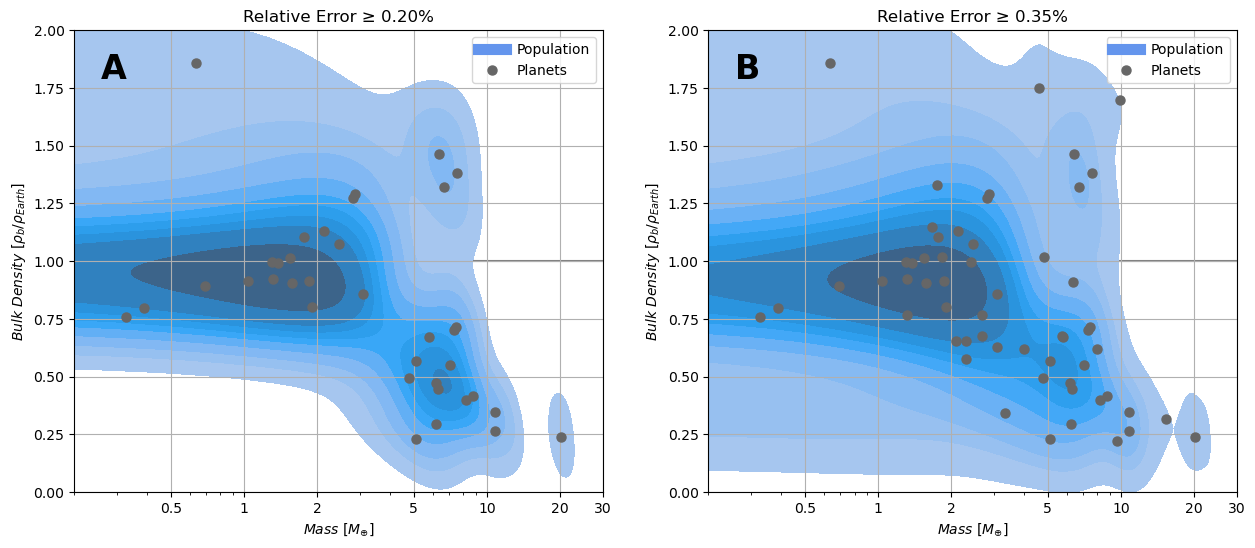

In [296]:
fig, ax = plt.subplots(figsize=(15,6))

# Add subplot A
plt.subplot(1, 2, 1)
plt.text(0.05, 0.95, "A", transform=plt.gca().transAxes, fontsize=24, fontweight='bold', va='top', ha='left')
EA_planets = filter_planets(planet_name_EA,0.20,0.20)
index,planet,radius,radius_up,radius_low,density,density_up,density_low,mass,mass_up,mass_low = make_lists(EA_planets)
num_samples = 30

radii = []; masses = []; densitys = []
for i in range(0,len(mass)):
    mean_mass = mass[i]; mass_lower_err = np.abs(mass_low[i]);  mass_upper_err = mass_up[i]
    
    mean_density = np.divide(density,earth_density)[i]; 
    density_lower_err = np.divide(np.abs(density_low[i]),earth_density);  
    density_upper_err = np.divide(density_up,earth_density)[i]

    # Number of posterior samples to generate
    mass_samples = np.random.normal(mean_mass, (mass_lower_err + mass_upper_err) / 2, num_samples)
    masses.append(mass_samples)
    density_samples = np.random.normal(mean_density, (density_lower_err + density_upper_err) / 2, num_samples)
    densitys.append(density_samples)

masses_flattened = [item for sublist in masses for item in sublist]
radii_flattened = [item for sublist in radii for item in sublist]
densitys_flattened = [item for sublist in densitys for item in sublist]

# Create a 2D density colormap plot using KDE
sns.kdeplot(x =masses_flattened,y=densitys_flattened, fill=True,)
plt.plot(100,100,label="Population",color = "cornflowerblue")
mass_err         = [np.abs(mass_low),mass_up]
density_err      = [np.divide(np.abs(density_low),earth_density),np.divide(density_up,earth_density)]

plt.plot(mass,np.divide(density,earth_density),".",label = "Planets",color = "0.4",markersize = 13,zorder=10)
#plt.errorbar(mass,np.divide(density,earth_density),xerr = mass_err, yerr = density_err,fmt=".",color="0.8",zorder=1)
plt.title('Relative Error ≥ 0.20%')
plt.xlabel("$Mass\ [M_{\oplus}]$"); plt.ylabel("$Bulk\ Density\ [ρ_{b}/ρ_{Earth}]$"); plt.xscale("log");
plt.ylim(0,2); plt.xlim(0.2,30); plt.xticks([0.5,1,2,5,10,20, 30],["0.5","1","2","5","10","20", "30"],minor=False); plt.grid(); plt.hlines(1,0,30,"grey",zorder = -30); 
leg = plt.legend()
for line in leg.get_lines():
    line.set_linewidth(8.0)

# Add subplot B
plt.subplot(1, 2, 2)
plt.text(0.05, 0.95, "B", transform=plt.gca().transAxes, fontsize=24, fontweight='bold', va='top', ha='left')
EA_planets = filter_planets(planet_name_EA,0.35,0.35)
index,planet,radius,radius_up,radius_low,density,density_up,density_low,mass,mass_up,mass_low = make_lists(EA_planets)
num_samples = 30

radii = []; masses = []; densitys = []
for i in range(0,len(mass)):
    mean_mass = mass[i]; mass_lower_err = np.abs(mass_low[i]);  mass_upper_err = mass_up[i]
    
    mean_density = np.divide(density,earth_density)[i]; 
    density_lower_err = np.divide(np.abs(density_low[i]),earth_density);  
    density_upper_err = np.divide(density_up,earth_density)[i]

    # Number of posterior samples to generate
    mass_samples = np.random.normal(mean_mass, (mass_lower_err + mass_upper_err) / 2, num_samples)
    masses.append(mass_samples)
    density_samples = np.random.normal(mean_density, (density_lower_err + density_upper_err) / 2, num_samples)
    densitys.append(density_samples)

masses_flattened = [item for sublist in masses for item in sublist]
radii_flattened = [item for sublist in radii for item in sublist]
densitys_flattened = [item for sublist in densitys for item in sublist]

# Create a 2D density colormap plot using KDE
sns.kdeplot(x =masses_flattened,y=densitys_flattened, fill=True,)
plt.plot(100,100,label="Population",color = "cornflowerblue")
mass_err         = [np.abs(mass_low),mass_up]
density_err      = [np.divide(np.abs(density_low),earth_density),np.divide(density_up,earth_density)]

plt.plot(mass,np.divide(density,earth_density),".",label = "Planets",color = "0.4",markersize = 13,zorder=10)
#plt.errorbar(mass,np.divide(density,earth_density),xerr = mass_err, yerr = density_err,fmt=".",color="0.8",zorder=1)
plt.title('Relative Error ≥ 0.35%')
plt.xlabel("$Mass\ [M_{\oplus}]$"); plt.ylabel("$Bulk\ Density\ [ρ_{b}/ρ_{Earth}]$"); plt.xscale("log");
plt.ylim(0,2); plt.xlim(0.2,30); plt.xticks([0.5,1,2,5,10,20, 30],["0.5","1","2","5","10","20", "30"],minor=False); plt.grid(); plt.hlines(1,0,30,"grey",zorder = -30); 
leg = plt.legend()
for line in leg.get_lines():
    line.set_linewidth(8.0)

folder_path = 'Figures_WhereAreTheWaterWorlds'
if not os.path.exists(folder_path):
    os.makedirs(folder_path)

# Define the image name within the folder
image_name = os.path.join(folder_path, 'SMEAR_error.png')

# Set the image format
image_format = 'png'

# Save the figure
fig.savefig(image_name, format=image_format, dpi=1200)

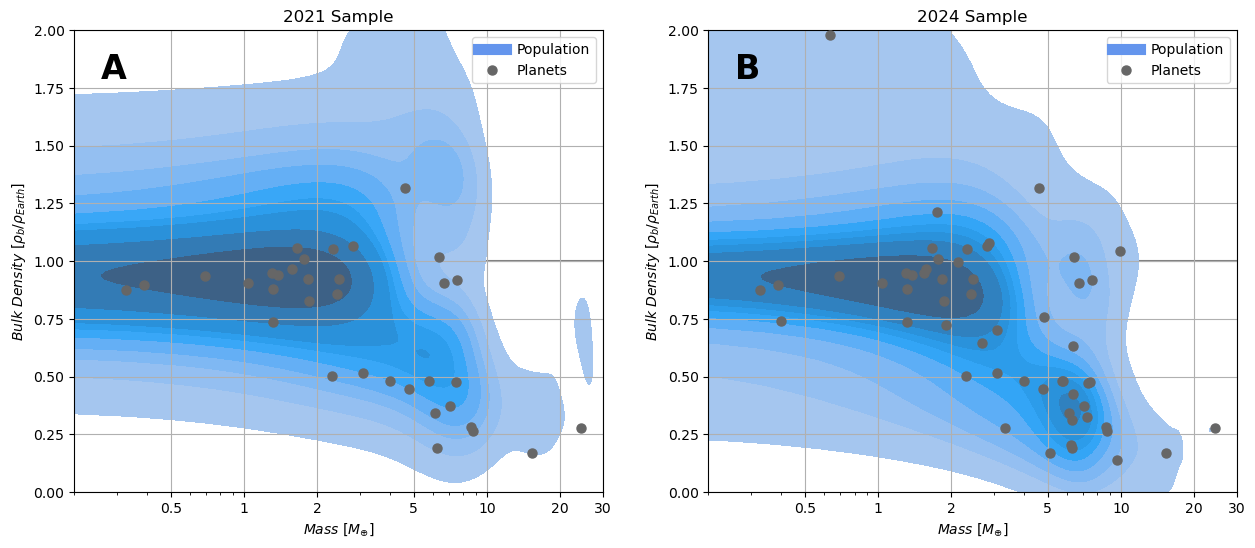

In [295]:
fig, ax = plt.subplots(figsize=(15,6))

mass    = np.concatenate((mass1, mass2));       mass_up     = np.concatenate((mass_up1, mass_up2));       mass_low     = np.concatenate((mass_low1, mass_low2));
radius  = np.concatenate((radius1, radius2));   radius_up   = np.concatenate((radius_up1, radius_up2));   radius_low   = np.concatenate((radius_low1, radius_low2));
density = np.concatenate((np.array(density1) / rocky_density(mass1), np.array(density2)/ rocky_density(mass2))); density_up  = np.concatenate((np.array(density_up1)/ rocky_density(mass1), np.array(density_up2)/ rocky_density(mass2))); density_low  = np.concatenate((np.array(density_low1)/ rocky_density(mass1),np.array(density_low2)/ rocky_density(mass2)));

# Add subplot A
plt.subplot(1, 2, 1)
plt.text(0.05, 0.95, "A", transform=plt.gca().transAxes, fontsize=24, fontweight='bold', va='top', ha='left')

num_samples = 30
radii = []; masses = []; densitys = []
for i in range(0,len(mass1)):
    mean_mass = mass1[i]; mass_lower_err = np.abs(mass_low1[i]);  mass_upper_err = mass_up1[i]
    
    mean_density = np.divide(density1,earth_density)[i]; 
    density_lower_err = np.divide(np.abs(density_low1[i]),earth_density);  
    density_upper_err = np.divide(density_up1,earth_density)[i]

    mass_samples = np.random.normal(mean_mass, (mass_lower_err + mass_upper_err) / 2, num_samples)
    masses.append(mass_samples)
    density_samples = np.random.normal(mean_density, (density_lower_err + density_upper_err) / 2, num_samples)
    densitys.append(density_samples)

masses_flattened = [item for sublist in masses for item in sublist]
radii_flattened = [item for sublist in radii for item in sublist]
densitys_flattened = [item for sublist in densitys for item in sublist]

# Create a 2D density colormap plot using KDE
sns.kdeplot(x =masses_flattened,y=densitys_flattened, fill=True,)
plt.plot(100,100,label="Population",color = "cornflowerblue")
mass_err         = [np.abs(mass_low1),mass_up1]
density_err      = [density_low1,density_up1]

plt.plot(mass1,np.array(density1) / rocky_density(mass1),".",label = "Planets",color = "0.4",markersize = 13,zorder=10)
#plt.errorbar(mass,np.divide(density,earth_density),xerr = mass_err, yerr = density_err,fmt=".",color="0.8",zorder=1)
plt.title('2022 Sample')
plt.xlabel("$Mass\ [M_{\oplus}]$"); plt.ylabel("$Bulk\ Density\ [ρ_{b}/ρ_{Earth}]$"); plt.xscale("log");
plt.ylim(0,2); plt.xlim(0.2,30); plt.xticks([0.5,1,2,5,10,20, 30],["0.5","1","2","5","10","20", "30"],minor=False); plt.grid(); plt.hlines(1,0,30,"grey",zorder = -30); 
leg = plt.legend()
for line in leg.get_lines():
    line.set_linewidth(8.0)

# Add subplot B
plt.subplot(1, 2, 2)
plt.text(0.05, 0.95, "B", transform=plt.gca().transAxes, fontsize=24, fontweight='bold', va='top', ha='left')

mass    = np.concatenate((mass1, mass2));       mass_up     = np.concatenate((mass_up1, mass_up2));       mass_low     = np.concatenate((mass_low1, mass_low2));
radius  = np.concatenate((radius1, radius2));   radius_up   = np.concatenate((radius_up1, radius_up2));   radius_low   = np.concatenate((radius_low1, radius_low2));
density = np.concatenate((np.array(density1) / rocky_density(mass1), np.array(density2)/ rocky_density(mass2))); density_up  = np.concatenate((np.array(density_up1)/ rocky_density(mass1), np.array(density_up2)/ rocky_density(mass2))); density_low  = np.concatenate((np.array(density_low1)/ rocky_density(mass1),np.array(density_low2)/ rocky_density(mass2)));

radii = []; masses = []; densitys = []
for i in range(0,len(mass)):
    mean_mass = mass[i]; mass_lower_err = np.abs(mass_low[i]);  mass_upper_err = mass_up[i]
    
    mean_density = density[i]; 
    density_lower_err = np.abs(density_low)[i];  
    density_upper_err = density_up[i];

    # Number of posterior samples to generate
    mass_samples = np.random.normal(mean_mass, (mass_lower_err + mass_upper_err) / 2, num_samples)
    masses.append(mass_samples)
    density_samples = np.random.normal(mean_density, (density_lower_err + density_upper_err) / 2, num_samples)
    densitys.append(density_samples)

masses_flattened = [item for sublist in masses for item in sublist]
radii_flattened = [item for sublist in radii for item in sublist]
densitys_flattened = [item for sublist in densitys for item in sublist]

# Create a 2D density colormap plot using KDE
sns.kdeplot(x =masses_flattened,y=densitys_flattened, fill=True,)
plt.plot(100,100,label="Population",color = "cornflowerblue")
mass_err         = [np.abs(mass_low),mass_up]
density_err      = [np.divide(np.abs(density_low),earth_density),np.divide(density_up,earth_density)]

plt.plot(mass,density,".",label = "Planets",color = "0.4",markersize = 13,zorder=10)
#plt.errorbar(mass,np.divide(density,earth_density),xerr = mass_err, yerr = density_err,fmt=".",color="0.8",zorder=1)
plt.title('2024 Sample')
plt.xlabel("$Mass\ [M_{\oplus}]$"); plt.ylabel("$Bulk\ Density\ [ρ_{b}/ρ_{Earth}]$"); plt.xscale("log");
plt.ylim(0,2); plt.xlim(0.2,30); plt.xticks([0.5,1,2,5,10,20, 30],["0.5","1","2","5","10","20", "30"],minor=False); plt.grid(); plt.hlines(1,0,30,"grey",zorder = -30); 
leg = plt.legend()
for line in leg.get_lines():
    line.set_linewidth(8.0)

folder_path = 'Figures_WhereAreTheWaterWorlds'
if not os.path.exists(folder_path):
    os.makedirs(folder_path)

# Define the image name within the folder
image_name = os.path.join(folder_path, 'SEMAR_compare.png')

# Set the image format
image_format = 'png'

# Save the figure
fig.savefig(image_name, format=image_format, dpi=1200)

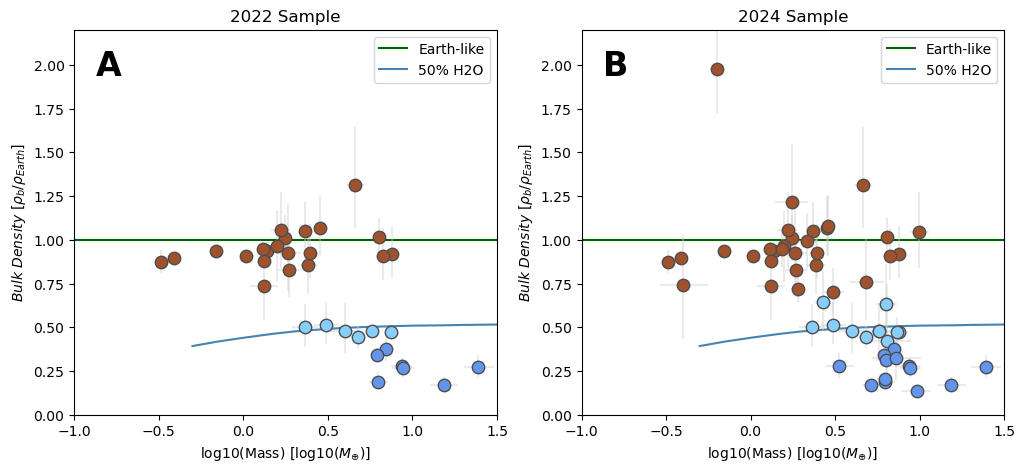

In [461]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
# Add subplot A
ax = axes[0]
ax.plot(np.log10(earth_like_rocky["Mass"]), np.array(rocky_density(list(earth_like_rocky["Mass"]))) / np.array(rocky_density(list(earth_like_rocky["Mass"]))), "-", color="Darkgreen", label="Earth-like", zorder=-32)
ax.plot(np.log10(H20_50_500K["Mass"]), H20_50_500K_density_g_cm3 / rocky_density(H20_50_500K["Mass"]), "-", color="steelblue", label="50% H2O", zorder=-32)
index_puffy = []; index_water = []; index_rocky = []
for i in range(0, len(density1)):
    if density1_norm[i] - np.abs(density_low1_norm[i]) > h20model_density(mass1[i]):
        index_rocky.append(i)
    elif density1_norm[i] - np.abs(density_low1_norm[i]) < h20model_density(mass1[i]) and density1_norm[i] + np.abs(density_up1_norm[i]) > h20model_density(mass1[i]):
        index_water.append(i)
    else: 
        index_puffy.append(i)

ax.scatter(np.array(np.log10(mass1))[index_rocky], density_norm_planet[index_rocky],color = "sienna",s=80, edgecolor = "0.3")
ax.scatter(np.array(np.log10(mass1))[index_water], density_norm_planet[index_water],color = "lightskyblue",s=80, edgecolor = "0.3")
ax.scatter(np.array(np.log10(mass1))[index_puffy], density_norm_planet[index_puffy],color = "cornflowerblue",s=80, edgecolor = "0.3")
ax.errorbar(np.log10(mass1), density_norm_planet, xerr=mass10_err1, yerr=density_err1, fmt='.', markersize=15, color="0.8", zorder=-32, alpha=0.4)

ax.set_xlim(-1, 1.5); ax.set_ylim(0, 2.2)
ax.set_xlabel("log10(Mass) [log10($M_{\oplus})]$")
ax.set_ylabel("$Bulk\ Density\ [ρ_{b}/ρ_{Earth}]$")
ax.legend(loc=1)
ax.text(0.05, 0.95, "A", transform=ax.transAxes, fontsize=24, fontweight='bold', va='top', ha='left')
ax.set_title("2022 Sample")

# Add subplot B
ax = axes[1]
ax.plot(np.log10(earth_like_rocky["Mass"]), np.array(rocky_density(list(earth_like_rocky["Mass"]))) / np.array(rocky_density(list(earth_like_rocky["Mass"]))), "-", color="Darkgreen", label="Earth-like", zorder=-32)
ax.plot(np.log10(H20_50_500K["Mass"]), H20_50_500K_density_g_cm3 / rocky_density(H20_50_500K["Mass"]), "-", color="steelblue", label="50% H2O", zorder=-32)
index_puffy = []; index_water = []; index_rocky = []
for i in range(0, len(density)):
    if density[i] - np.abs(density_low[i]) > h20model_density(mass[i]):
        index_rocky.append(i)
    elif density[i] - np.abs(density_low[i]) < h20model_density(mass[i]) and density[i] + np.abs(density_up[i]) > h20model_density(mass[i]):
        index_water.append(i)
    else: 
        index_puffy.append(i)

ax.scatter(np.array(mass10)[index_rocky], density[index_rocky],color = "sienna",s=80, edgecolor = "0.3")
ax.scatter(np.array(mass10)[index_water], density[index_water],color = "lightskyblue",s=80, edgecolor = "0.3")
ax.scatter(np.array(mass10)[index_puffy], density[index_puffy],color = "cornflowerblue",s=80, edgecolor = "0.3")
ax.errorbar(mass10, density, xerr=mass10_err, yerr=density_err, fmt='.', markersize=15, color="0.8", zorder=-32, alpha=0.4)
ax.set_xlim(-1, 1.5); ax.set_ylim(0, 2.2)
ax.set_xlabel("log10(Mass) [log10($M_{\oplus})]$")
ax.set_ylabel("$Bulk\ Density\ [ρ_{b}/ρ_{Earth}]$")
ax.legend(loc=1)
ax.text(0.05, 0.95, "B", transform=ax.transAxes, fontsize=24, fontweight='bold', va='top', ha='left')
ax.set_title("2024 Sample")

folder_path = 'Figures_WhereAreTheWaterWorlds'
if not os.path.exists(folder_path):
    os.makedirs(folder_path)

# Define the image name within the folder
image_name = os.path.join(folder_path, 'LP_catagorization_compare.png')

# Set the image format
image_format = 'png'

# Save the figure
fig.savefig(image_name, format=image_format, dpi=1200)

In [457]:
density_norm1

NameError: name 'density_norm1' is not defined